In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# Set a shorter path for TensorFlow Datasets
os.environ['TFDS_DATA_DIR'] = 'tensorflow_datasets'

In [ ]:
# Load the Plant Village dataset
(ds_train, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tensorflow_datasets/plant_village/incomplete.3KB8KG_1.0.2/plant_village-train.tfrecord*...:   0%|   …

Dataset plant_village downloaded and prepared to tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [ ]:
# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label


In [ ]:
# Apply preprocessing
ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Build a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(ds_train, epochs=1, validation_data=ds_test)

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1162s 854ms/step - accuracy: 0.5944 - loss: 1.5049 - val_accuracy: 0.8280 - val_loss: 0.5484


In [ ]:
# Evaluate the model
loss, acc = model.evaluate(ds_test)
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {acc:.2f}")

340/340 ━━━━━━━━━━━━━━━━━━━━ 81s 236ms/step - accuracy: 0.8292 - loss: 0.5571
Test Loss: 0.55
Test Accuracy: 0.83


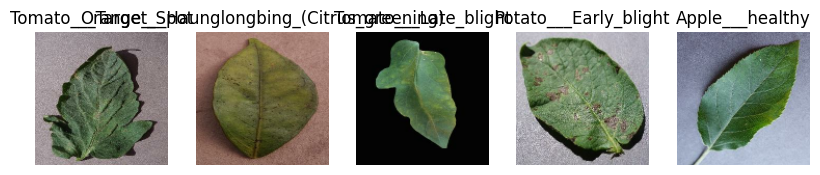

In [ ]:
# Display 5 sample images from the training set
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(1)):  # Get just one batch from ds_train
    for j in range(5):
        ax = plt.subplot(5, 5, j + 1)
        img = image[j].numpy()  # Get the jth image in the batch
        plt.imshow((img * 255).astype("uint8"))  # Convert to uint8
        plt.title(ds_info.features['label'].int2str(label[j].numpy()))
        plt.axis("off")
plt.show()

In [ ]:
# Predict for one test image using its index
index = 69  # Change this to the desired index

In [ ]:
# Fetch the specific test image
test_image = ds_test.skip(index).take(1)  # Skip the first 'index' elements and take one batch
for image, label in test_image:
    image = image[1]  # Get the first image from the batch


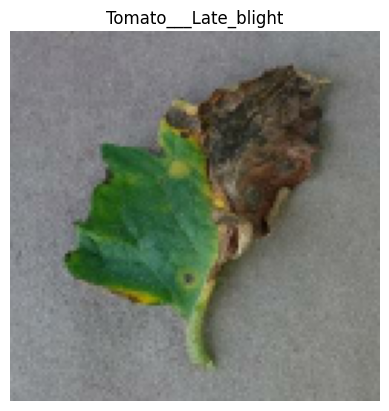

In [ ]:
# Display the test image
plt.imshow((image.numpy() * 255).astype("uint8"))  # Multiply by 255 for conversion
plt.title(ds_info.features['label'].int2str(label[0].numpy()))
plt.axis("off")
plt.show()

In [ ]:
# Make the prediction
prediction = model.predict(tf.expand_dims(image, axis=0))
predicted_label = tf.argmax(prediction, axis=1).numpy()[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


In [ ]:
# Print the prediction
print("Predicted Label:", ds_info.features['label'].int2str(predicted_label))


Predicted Label: Tomato___Late_blight
